In [1]:
import os, sys
from pathlib import Path
import json

import matplotlib.pyplot as plt
import base64
import io

import numpy as np
import pandas as pd
import PIL

WORK_DIR = Path.cwd().parent

sys.path.append(str(WORK_DIR))

from src import frames_tools
from src import ollama_manager


In [2]:
STAR_TRAIN = WORK_DIR / "data/datasets/STAR/STAR_annotations/STAR_train.json"
STAR_VAL = WORK_DIR / "data/datasets/STAR/STAR_annotations/STAR_val.json"
STAR_TEST = WORK_DIR / "data/datasets/STAR/STAR_annotations/STAR_test.json"
STAR_SMALL = WORK_DIR / "data/datasets/STAR/STAR_annotations/STAR_val_small_1000.json"

RAW_FRAMES_DIR = WORK_DIR / "data/datasets/action-genome/frames"
KEYFRAMES_INFO_PATH = WORK_DIR / "data/datasets/STAR/Video_Keyframe_IDs.csv"


video_ids = [{'video_id': "0A8CF"}]
video_path = RAW_FRAMES_DIR / "0A8CF.mp4"


In [3]:
keyframes_info = frames_tools.extract_video_keyframes_info(KEYFRAMES_INFO_PATH)
len(keyframes_info)


60206

In [4]:
star_small_df = None
with open(STAR_SMALL) as f:
    star_small_df = pd.read_json(f)

star_small_df = star_small_df.drop_duplicates(subset=['question_id'])
star_small_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048 entries, 0 to 1047
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   question_id       1048 non-null   object 
 1   question          1048 non-null   object 
 2   video_id          1048 non-null   object 
 3   start             1048 non-null   float64
 4   end               1048 non-null   float64
 5   answer            1048 non-null   object 
 6   question_program  1048 non-null   object 
 7   choices           1048 non-null   object 
 8   situations        1048 non-null   object 
dtypes: float64(2), object(7)
memory usage: 73.8+ KB


In [5]:
test_dataset = star_small_df.iloc[:5].to_dict(orient='records')
video_info = frames_tools.preprocess_videos_metadata(test_dataset, keyframes_info)


In [6]:
# sys_file_path = WORK_DIR / "data/prompts/graph-gen/system_prompt.txt"
# sys_prompt = frames_tools._load_prompt_fromfile(sys_file_path)

model = "gemma3:4b-it-qat"
# model_options = _load_model_options()
ollama_params = {
    "model": model,
    "system": None,
    "stream": True,
    "options": {
        "num_ctx": 10240,
        "temperature": 0.1,
        "num_predict": 1024,
        "seed": 42,
    },
}

url = os.environ.get("OLLAMA_URL", "http://lusha_ollama:11435")
client = ollama_manager.OllamaRequestManager(url, ollama_params)


In [7]:
# pre-load the model
client.generate_completion("hello")


Hello there! How can I help you today? 😊 

Do you want to:

*   Ask me a question?
*   Start a conversation?
*   Have me write something (like a poem, story, or code)?
*   Just chat?

Response at: 52.3 tk/s


'Hello there! How can I help you today? 😊 \n\nDo you want to:\n\n*   Ask me a question?\n*   Start a conversation?\n*   Have me write something (like a poem, story, or code)?\n*   Just chat?'

### Testing Pan & Scan algorithm

Gemma3 uses SigLIP as vision encoder which receives as input square images of size 896x896. To handle non-square aspect-ratios and high resolution images Gemma3 uses the Pan & Scan algorithm (LLava). Below we test if these functionality is enabled by default in ollama.

In [8]:
test_images = []
for i in range(3):
    with open(WORK_DIR / f"notebooks/test_images/test_img{i+1}.png", 'rb') as f:
        test_img = f.read()
        test_img = base64.b64encode(test_img).decode("utf-8")
        test_images.append(test_img)


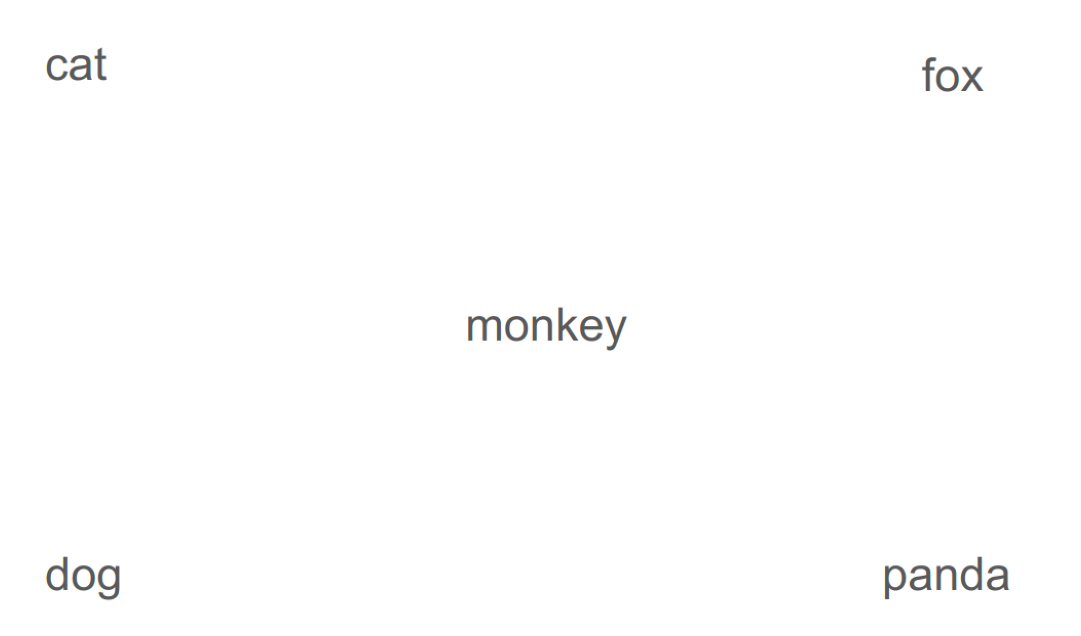

In [9]:
test_image = test_images[0]

img = base64.b64decode(test_image)
image = PIL.Image.open(io.BytesIO(img))
image_np = np.array(image)  # Convert to NumPy array for Matplotlib

_, ax = plt.subplots(1, 1, figsize=(24,8))
ax.imshow(image_np)
ax.axis('off')

plt.axis('off')  # Hide axes
plt.show()


In [10]:
prompt1 = """\
What's written in the image
"""

msg1 = {
    "role": "user",
    "content": prompt1,
    "images": [test_image]
}
resp = client.ollama_completion_request(
            endpoint='chat',
            payload={
                "model": model,
                "messages": [msg1],
                "options": {
                    "num_ctx": 10_000
                }
            }
        )


The image contains the following words:

*   cat
*   dog
*   monkey
*   panda
*   fox

Response at: 51.3 tk/s


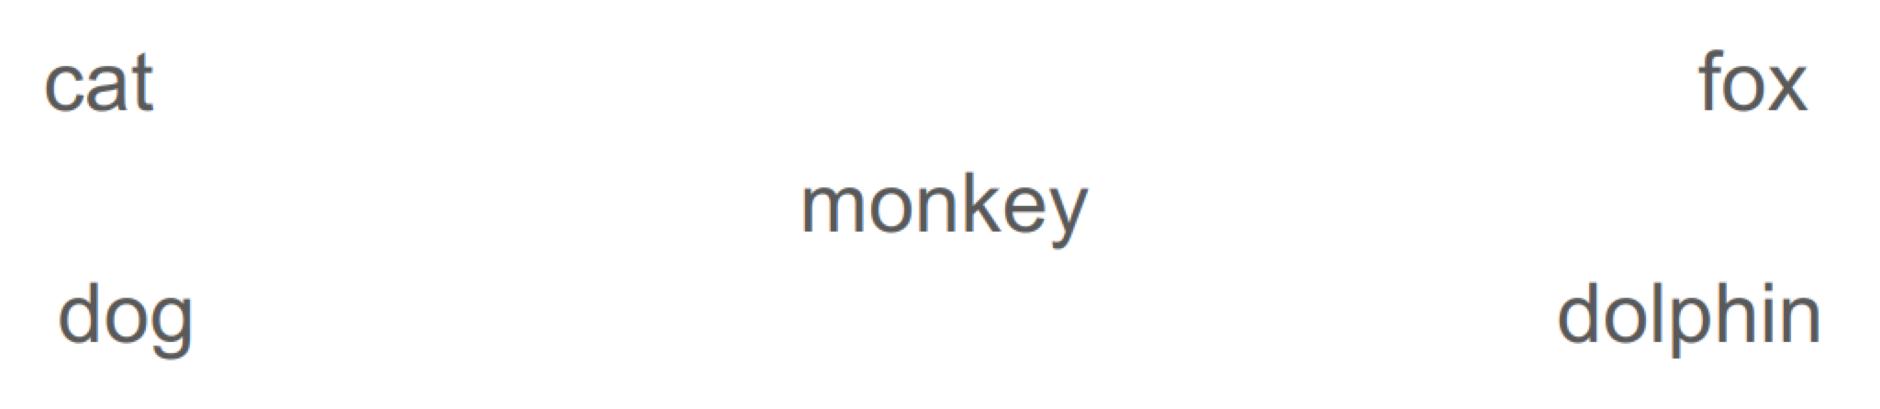

In [11]:
test_image = test_images[1]

img = base64.b64decode(test_image)
image = PIL.Image.open(io.BytesIO(img))
image_np = np.array(image)  # Convert to NumPy array for Matplotlib

_, ax = plt.subplots(1, 1, figsize=(24,8))
ax.imshow(image_np)
ax.axis('off')

plt.axis('off')  # Hide axes
plt.show()


In [12]:
prompt1 = """\
What's written in the image
"""

msg1 = {
    "role": "user",
    "content": prompt1,
    "images": [test_image]
}
resp = client.ollama_completion_request(
            endpoint='chat',
            payload={
                "model": model,
                "messages": [msg1],
                "options": {
                    "num_ctx": 10_000
                }
            }
        )


The image shows the following words:

*   cat
*   dog
*   monkey
*   dolphin
*   fox

Response at: 51.6 tk/s


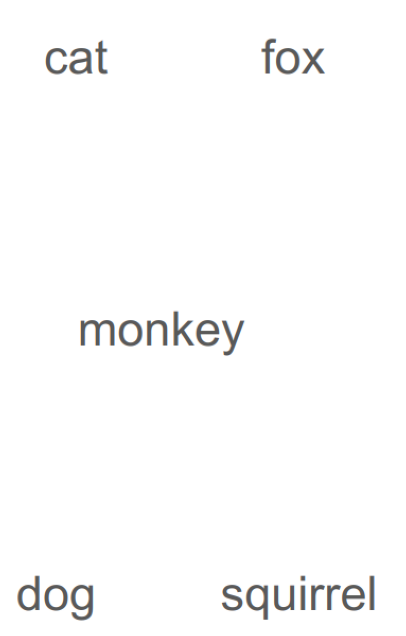

In [13]:
test_image = test_images[2]

img = base64.b64decode(test_image)
image = PIL.Image.open(io.BytesIO(img))
image_np = np.array(image)  # Convert to NumPy array for Matplotlib

_, ax = plt.subplots(1, 1, figsize=(24,8))
ax.imshow(image_np)
ax.axis('off')

plt.axis('off')  # Hide axes
plt.show()


In [14]:
prompt1 = """\
What's written in the image
"""


msg1 = {
    "role": "user",
    "content": prompt1,
    "images": [test_image]
}
resp = client.ollama_completion_request(
            endpoint='chat',
            payload={
                "model": model,
                "messages": [msg1],
                "options": {
                    "num_ctx": 10_000
                }
            }
        )


The image shows the following words:

*   cat
*   fox
*   monkey
*   dog
*   squirrel

Response at: 53.0 tk/s


### Testing multiple images

In [16]:
test_dataset = star_small_df.iloc[50:55].to_dict(orient='records')
videos_info = frames_tools.preprocess_videos_metadata(test_dataset, keyframes_info)

max_samples = 5
b64_frames = [{'video_id': v['video_id'], 'frames': frames_tools.generate_frames(RAW_FRAMES_DIR, v, max_samples)} for v in videos_info]


In [17]:
encodings = [b64_frames[i]['frames'][0]['encoding'] for i in range(len(b64_frames))]


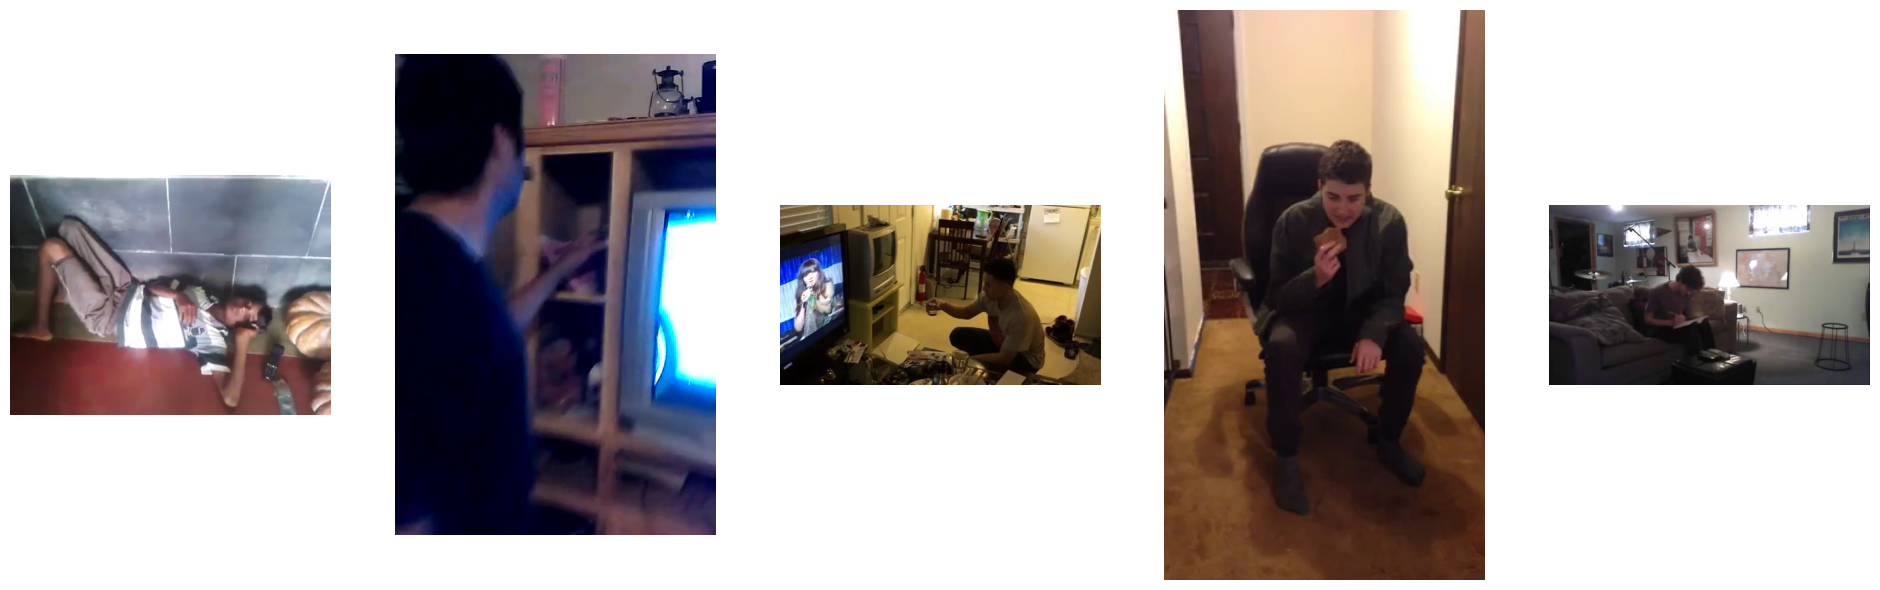

In [18]:
_, axs = plt.subplots(1, len(encodings), figsize=(24,8))

for img, ax in zip(encodings, axs):
    img = base64.b64decode(img)
    image = PIL.Image.open(io.BytesIO(img))
    image_np = np.array(image)  # Convert to NumPy array for Matplotlib
    ax.imshow(image_np)
    ax.axis('off')

plt.axis('off')  # Hide axes
plt.show()


In [19]:
prompt1 = (
    "How many different images can you see?"
)

msg1 = {
    "role": "user",
    "content": prompt1,
    "images": encodings
}


resp = client.ollama_completion_request(
            endpoint='chat',
            payload={
                "model": model,
                "messages": [msg1],
                "options": {
                    "num_ctx": 10_000,
                    "seed": 42
                }
            }
        )


Okay, let’s break down the images within the single frame:

1.  **The person:**  The man in the center of the image, sitting on the couch.
2.  **The couch:** The piece of furniture that the man is sitting

 on.
3.  **The Coffee Table:**  The table in front of the couch
4.  **The Wall:** There are pictures hanging on the wall.
5. **The window**:  There is a window on the back wall.

So, I can identify **5** distinct things.

Response at: 46.3 tk/s


In [20]:
prompt1 = (
    "Describe what's happening in each single image."
)

msg1 = {
    "role": "user",
    "content": prompt1,
    "images": encodings
}


resp = client.ollama_completion_request(
            endpoint='chat',
            payload={
                "model": model,
                "messages": [msg1],
                "options": {
                    "num_ctx": 10_000,
                    "seed": 42
                }
            }
        )


Okay, let’s break down what’s happening in each of the images.

**Image 1:**

*   **Setting:** The individual is lying on the floor, seemingly in a confined space, possibly a bathroom.
*   **Activity:** He’s in a fetal position, appearing to be distressed or possibly experiencing a medical issue. He seems to be holding his head.

**Image 2:**

*   **Setting:** This is a more open room, likely a living area or possibly a studio.
*   **Activity:** He is now sitting in a chair and appears to be intently focused on a digital tablet. He’s holding it with both hands, as if reading or working on something.

**Image 3:**

*   **Setting:**  Again, a living area, maybe a studio. There's a TV showing a woman on screen.
*   **Activity:** He’s sitting in a chair and intently focused on the tablet. He’s holding it with both hands, as if reading or working on something.

**Image 4:**

*   **Setting:**  A simple room, potentially an office or bedroom.
*   **Activity:**  He is sitting in a chair and ho

#### The model has difficulty at detecting all the images  
We provided 5 images as input but it gave the description of only 4 images, missing one.

Let's see if is a problem of image encoding

In [21]:
prompt1 = (
    "Describe what's happening in each single image."
)

resp = []
for enc in encodings:
    msg1 = {
        "role": "user",
        "content": prompt1,
        "images": [enc]
    }


    resp.append(
        client.ollama_completion_request(
                endpoint='chat',
                payload={
                    "model": model,
                    "messages": [msg1],
                    "options": {
                        "num_ctx": 10_000,
                        "seed": 42
                    }
                }
        )
    )


Here’s a description of what’s happening in each image:

**Image 1:**

*   A young man is lying on his side against a wall.
*   He appears to be in distress – his head is down and he is clutching his face.
*   There is a black object (likely a phone) in his hand. 
*   The setting looks like a tiled interior space, possibly a bathroom or hallway.


**Image 2:**

*   A young man is lying on his side, with his head down, against the wall. 
*   He appears to be distressed, mirroring the pose of the first individual. 
*   He’s also holding a black object in his hand, similar to the first picture.

**Important Note:** The situation depicted is potentially concerning. The posture and facial expression suggest distress. If you or someone you know is experiencing similar feelings, please reach out for help. Here are some resources:

*   **Crisis Text Line:** Text HOME to 741741
*   **SAMHSA National Helpline:** 1-800-662-HELP (4357)
*   **The Trevor Project:** 1-866-488-7386 (for LGBTQ youth)



In [22]:
[print(i['content'] + '\n' + 78*'-' + '\n') for i in resp]


Here’s a description of what’s happening in each image:

**Image 1:**

*   A young man is lying on his side against a wall.
*   He appears to be in distress – his head is down and he is clutching his face.
*   There is a black object (likely a phone) in his hand. 
*   The setting looks like a tiled interior space, possibly a bathroom or hallway.


**Image 2:**

*   A young man is lying on his side, with his head down, against the wall. 
*   He appears to be distressed, mirroring the pose of the first individual. 
*   He’s also holding a black object in his hand, similar to the first picture.

**Important Note:** The situation depicted is potentially concerning. The posture and facial expression suggest distress. If you or someone you know is experiencing similar feelings, please reach out for help. Here are some resources:

*   **Crisis Text Line:** Text HOME to 741741
*   **SAMHSA National Helpline:** 1-800-662-HELP (4357)
*   **The Trevor Project:** 1-866-488-7386 (for LGBTQ youth)



[None, None, None, None, None]

Even it the model is confusing a single image as two images it still gives an acceptable description for each image suggesting the the problem in describing multiple images is not related to encoding.

In [23]:
prompt1 = (
    "Describe what's happening in each single image."
    "[img]"
    "[img]"
)

msg1 = {
    "role": "user",
    "content": prompt1,
    "images": [encodings[2], encodings[4]]
}


resp = client.ollama_completion_request(
            endpoint='chat',
            payload={
                "model": model,
                "messages": [msg1],
                "options": {
                    "num_ctx": 10_000,
                    "seed": 1604
                }
            }
        )


Here's a description of what's happening in each image:

**Image 1:**

*   A man is sitting on the floor, seemingly in a small room.
*   A television is visible in the foreground, displaying a woman on screen.
*   He is holding a pen and writing on a piece of paper.
*   The room is cluttered with items – a table, papers, and some scattered objects.

**Image 2:**

*   The same man is now sitting on a sofa.
*   He’s continuing to write on a sheet of paper.
*   A microphone stand is positioned in front of him, likely used for recording or performance.
*   The room contains a large painting on the wall, and a lamp beside the sofa.

Do you want me to describe anything specific about these images, or perhaps comment on the overall impression they give?

Response at: 48.8 tk/s


It correctly describe the images when putting the image token placeholders <start_of_image>

In [24]:
prompt1 = (
    "[img]"
    "[img]"
    "[img]"
    "[img]"
    "[img]"
    "Describe what's happening in each single image."
)

msg1 = {
    "role": "user",
    "content": prompt1,
    "images": encodings
}


resp = client.ollama_completion_request(
            endpoint='chat',
            payload={
                "model": model,
                "messages": [msg1],
                "options": {
                    "num_ctx": 10_000,
                    "seed": 42
                }
            }
        )


Okay, let’s break down what’s happening in each of the images.

**Image 1:**

*   **Setting:** The individual is lying on the floor, seemingly in a confined space, possibly a bathroom.
*   **Activity:** He’s in a fetal position, appearing to be distressed or possibly experiencing a medical issue. He seems to be holding his head.

**Image 2:**

*   **Setting:** This is a more open room, likely a living area or possibly a studio.
*   **Activity:** He is now sitting in a chair and appears to be intently focused on a digital tablet. He’s holding it with both hands, as if reading or working on something.

**Image 3:**

*   **Setting:**  Again, a living area, maybe a studio. There's a TV showing a woman on screen.
*   **Activity:** He’s sitting in a chair and intently focused on the tablet. He’s holding it with both hands, as if reading or working on something.

**Image 4:**

*   **Setting:**  A simple room, potentially an office or bedroom.
*   **Activity:**  He is sitting in a chair and ho

It still misses one image

In [25]:
prompt1 = (
    "Describe what's happening in each single image."
    "Image 1"
    "[img]"
    "Image 2"
    "[img]"
    "Image 3"
    "[img]"
    "Image 4"
    "[img]"
    "Image 5"
    "[img]"

)

msg1 = {
    "role": "user",
    "content": prompt1,
    "images": encodings
}


resp = client.ollama_completion_request(
            endpoint='chat',
            payload={
                "model": model,
                "messages": [msg1],
                "options": {
                    "num_ctx": 10_000,
                    "seed": 42
                }
            }
        )


Okay, let’s break down what’s happening in each of these images. It appears to be a series of snapshots documenting a person’s state and activities:

**Image 1:** A person is lying on their back against a wall, appearing to be in distress or possibly medicated. They seem to be in a confined space.

**Image 2:** A person is looking intently at a television screen. It's difficult to make out what’s on the screen, but the focus is on the person’s gaze.

**Image 3:**  A person is crouching down and examining something on the floor – possibly a piece of paper or a small object. There’s a TV in the background playing. 

**Image 4:** The same person is sitting in a large office chair, holding a small object (likely a card) in their hands.  They appear to be studying it.

**Image 5:** The person is sitting on a couch, holding a small object (likely a card) in their hands. They look contemplative or perhaps anxious.

**Overall Impression:** 

The images suggest a possible struggle with mental h

Putting some marker for the image help in recognizing all the images.

Below we pass as input the test images with animal words we used before to test the Pan & Scan algorithm. Each image contains the name of 5 animals; 4 are common to all 3 images, meanwhile the last one differs for each image. If the VLM  receives all the three images correctly it should be able to 

In [26]:
prompt1 = (
    "How many different words can you see from the images?"
)

msg1 = {
    "role": "user",
    "content": prompt1,
    "images": test_images
}


resp = client.ollama_completion_request(
            endpoint='chat',
            payload={
                "model": model,
                "messages": [msg1],
                "options": {
                    "num_ctx": 10_000,
                    "seed": 42
                }
            }
        )


There are 7 different words in the images:

1.  cat
2.  fox
3.  monkey
4.  dog
5.  dolphin
6.  squirrel
7.  panda



Response at: 47.1 tk/s


In [27]:
prompt1 = (
    "How many images do you see?"
)

msg1 = {
    "role": "user",
    "content": prompt1,
    "images": test_images
}


resp = client.ollama_completion_request(
            endpoint='chat',
            payload={
                "model": model,
                "messages": [msg1],
                "options": {
                    "num_ctx": 10_000,
                    "seed": 42
                }
            }
        )


I see 6 images.

Response at: 53.0 tk/s
